In [194]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.cm import get_cmap
import seaborn as sns
from gekko import GEKKO
from lib import *

In [2]:
%load_ext autoreload
%autoreload 2

## Problem

Suppose we have state variable $x \in \mathbb{R}$ and **binary** control variable $i$ (i.e. it's just a switch with modes "off" = 0 and "on" = 1). Both depend on time $t$. We need to find such a solution

$$ 
F(\textbf{x}, \textbf{i}) \rightarrow
\min\limits_{\textbf{x}, \textbf{i}}
, \quad
\text{such that} \;\;
\left\{ \begin{array}{l}
x(0) = x_0 \\
\dot{x}(t) = f(x(t), i(t)) \\
\end{array} \right.
$$

where
* variables' paths
    * $\textbf{x} = [x(0), x(1), \dots, x(T)]$ - values of the state variable $x$ at time $t$
    * $\textbf{i} = [i(0), i(1), \dots, i(T-1)]$ - values of the **binary** control variable $i$ at time $t$

* objective function $F(\textbf{x}, \textbf{i}) = \frac{1}{2}\sum\limits^{T}_{t=0} (x(t) - x_{ref})^2$
* equality function $f(x, i) = x - i$
* parameters $T = 20, \ x_0 = 0.8, \ x_{ref} = 0.7$

Set the hyperparameters

In [310]:
# Time horizon:
T = 20
time_step = 0.05
time = np.arange(T + 1) * time_step

# Initial and reference state
x_0 = 0.8
x_ref = 0.7

Define the functions

In [311]:
# Differential equation:
def f(x, i):
    return x - i

# Objective function:
def F(x, i):
    return 0.5 * ((x - x_ref) ** 2)

### 1. Solve the problem with GEKKO

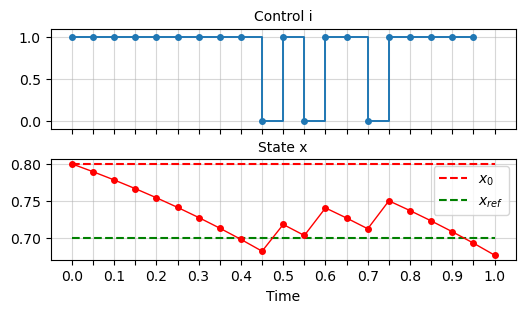

Objective value = 0.016295


In [312]:
history = optimal_control_minimization(x_0, x_ref, time, f, F, integer=True)
show(history)

### 2. Solve the corresponding relaxed problem (continuous) with GEKKO

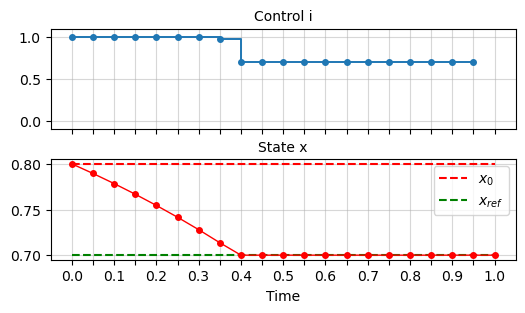

Objective value = 0.012129


In [313]:
history = optimal_control_minimization(x_0, x_ref, time, f, F, integer=False)
show(history)

### 3. Try to substitute a particular solution 

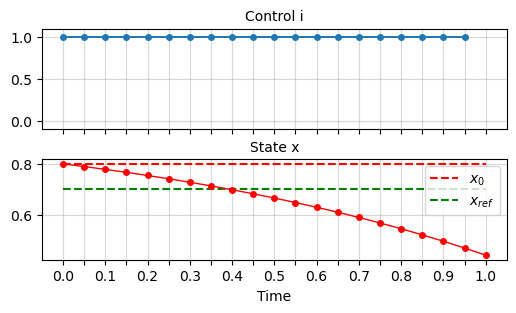

Objective value = 0.143637


In [314]:
const_i = [1] * (T + 1)
history = optimal_control_substituting(x_0, x_ref, time, f, F, const_i=const_i)
show(history)

### 4. Proposed method

Let's consider the binary vector $\textbf{i}$ as a random vector of independent random variables, where each variable $i(t)$ is Bernoulli distributed with the parameter $p_t$ (i.e. it takes the value 1 with probability $p$ and the value 0 with probability $1 - p$). To simplify further calculations a little let's write $i_t$ instead of $i(t)$

$$
\textbf{i} = 
[i_0, i_1, \dots, i_{T-1}] \sim q(\textbf{i}) = 
% q_0(i_0) \ q_1(i_1) \dots q_{N-1}(i_{N-1}) =
\prod\limits_{t=0}^{T-1} q_t(i_t), 
\quad
q_t(i) = \textbf{Bernoulli}\ (i \mid p_t)
$$


1. Sample $K$ vectors $\textbf{i}_1, \dots, \textbf{i}_K$ from $q(\textbf{i})$.
2. Compute the corresponding state trajectories $\textbf{x}_1, \dots, \textbf{x}_K$.
3. Compute the corresponding objective values $F_1, \dots, F_K = F(\textbf{x}_1, \textbf{i}_1), \dots, F(\textbf{x}_K, \textbf{i}_K)$.
4. Find $S$ best (minimal) values $F_{j_1}, \dots, F_{j_S}$ and corresponding control vectors $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_S}$.
5. Update the distribution $q(\textbf{i})$ as follows:
$$
q^{new}(\textbf{i}) = 
\prod\limits_{t=0}^{T-1} q^{new}_t(i_t), 
\quad
q^{new}_t(i) = \textbf{Bernoulli}\ (i \mid p^{new}_t), 
\quad 
p^{new}_t = \frac{1}{S} \sum\limits_{s=1}^{S} \textbf{i}_{j_s}(t) - 
\text{the $t$-th component of} \ \textbf{i}_{j_s}
$$
Simply put, we update the probability of success $p_t$ according to the number of ones on the $t$-th position in the best solutions $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_S}$.

6. Starting from $p_1 = \dots = p_{T-1} = 0.5$ we take $N$ steps of 1-5.

In [317]:
def sample(n_samples, probabilities):
    """
    Sample K binary vectors from q(p_1, ..., p_{T-1})
    params: 
        n_samples = K - number of samples
        probabilities - parameters p_1 ... p_{T-1}
    returns:
        I - samples
    """
    T = len(probabilities)
    I = np.random.rand(n_samples, T)
    I = (I <= probabilities).astype(np.int32)
    return I

In [328]:
def optimal_control_custom(x_0, x_ref, time, f, F, n_samples, top_s, n_steps):
    """
    params:
        x_0 - initial state
        x_ref - final reference state  
        time - time horizon
        f - differential equation
        F - objective function
        n_samples = K - number of samples
        top_s = S - number of the best solutions
        n_steps = N - number of steps
    returns:
        history: a dict with
            x - predicted state trjectory of x(t)
            i - given sequense of controls i(t)
            obj_val - corresponding objective value F(x, i)
        and some other items
    """
    p = np.ones_like(time) * 0.5
    history = {'p_trace' : [p], 'obj_val_trace': []}
    
    # main iteration loop : 6
    for step in range(n_steps):
        X = []
        Obj = []
        
        # sample and substitute solutions : 1-3
        I = sample(n_samples, p)
        for const_i in I:
            history_i = optimal_control_substituting(x_0, x_ref, time, f, F, const_i)
            X.append(history_i['x'])
            Obj.append(history_i['obj_val'])
        
        # find best solutions : 4
        top_S_id = np.argsort(Obj)[:top_s]
        
        print('-'*100)
        print(f'Step {step}/{n_steps} | Objective value {np.min(Obj):.5f}')
        w = [1.0 if k in top_S_id else 0.0 for k in range(n_samples)]
        show_X(X, x_0, x_ref, time, w, p)

        # update probabilities : 5
        p = I[top_S_id].mean(0)

        history['obj_val_trace'].append(Obj)
        history['p_trace'].append(p)

    best_id = np.argmin(Obj)
    history['time'] = time
    history['x'] = X[best_id]
    history['i'] = I[best_id]
    history['obj_val'] = Obj[best_id]
    history['x_0'] = x_0
    history['x_ref'] = x_ref
    history['obj_val_trace'] = np.array(history['obj_val_trace'])
    history['p_trace'] = np.array(history['p_trace'])
    return history

----------------------------------------------------------------------------------------------------
Step 0/5 | Objective value 0.17575


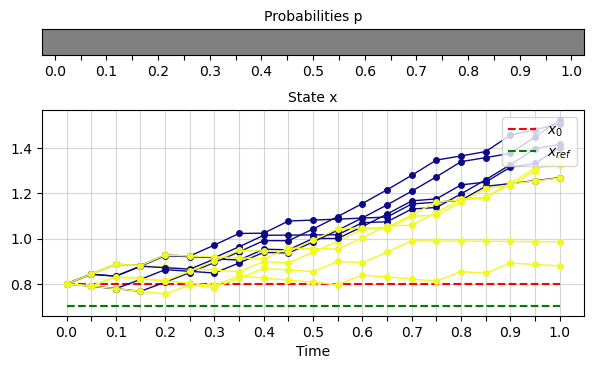

----------------------------------------------------------------------------------------------------
Step 1/5 | Objective value 0.23449


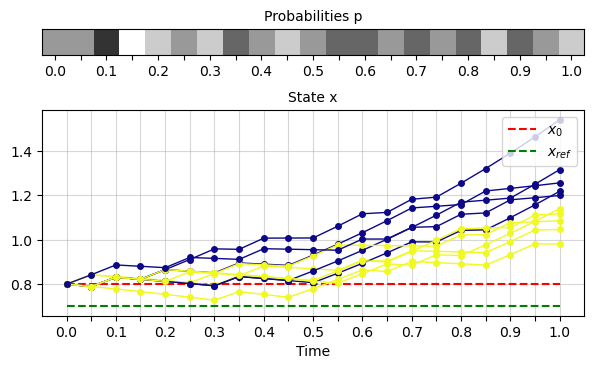

----------------------------------------------------------------------------------------------------
Step 2/5 | Objective value 0.01786


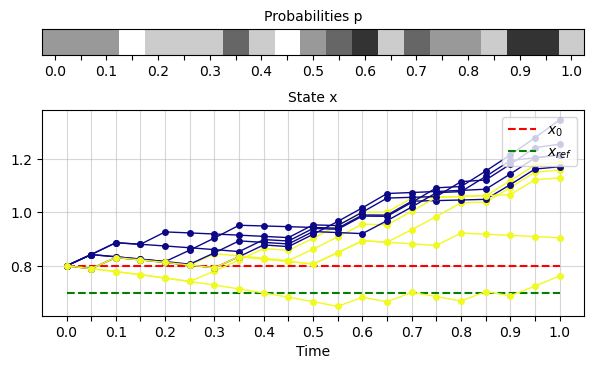

----------------------------------------------------------------------------------------------------
Step 3/5 | Objective value 0.07017


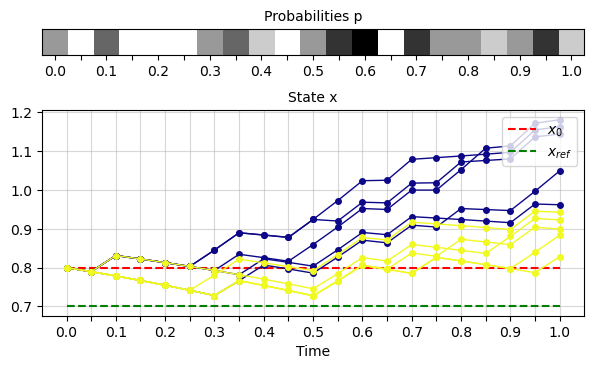

----------------------------------------------------------------------------------------------------
Step 4/5 | Objective value 0.04865


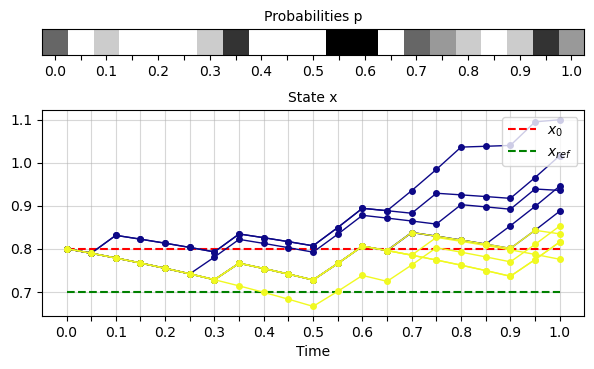

In [329]:
history = optimal_control_custom(x_0, x_ref, time, f, F, n_samples=10, top_s=5, n_steps=5)

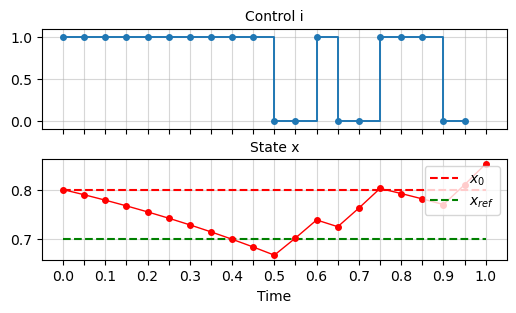

Objective value = 0.048650


In [330]:
show(history)

It's better than the GEKKO solution.

In [280]:
history['p_trace'][-1]

array([0. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 1. , 0.2, 1. , 1. ,
       1. , 1. , 1. , 0.8, 1. , 1. , 0. , 1. ])

As we can see, the final $p_1, \dots, p_{N-1}$ are almost binary. It means that the final $q(\textbf{i})$ is almost a delta-function centered in the optimal solution $\textbf{i}^*$.

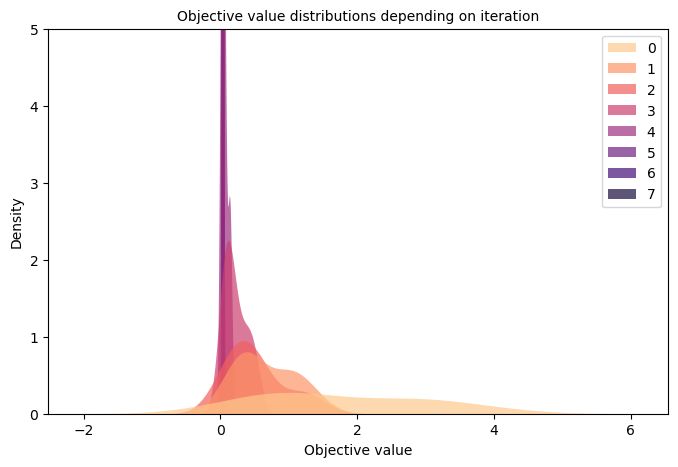

In [281]:
plt.figure(figsize=(8, 5))
plt.title('Objective value distributions depending on iteration', fontsize=10)
sns.kdeplot(
    data=history['obj_val_trace'].T,
    fill=True, common_norm=False, palette="magma_r",
    alpha=0.7, linewidth=0,
)
plt.xlabel('Objective value', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.ylim(0, 5)
plt.show()

As we can see, the distribution of objective value becames almost a delta-function centered in the minimum $F(\textbf{x}^*, \textbf{i}^*)$.

### 5. Proposed method: improvement 1

Вместо того чтобы брать топ-s решений $\textbf{i}_{j_1}, \dots, \textbf{i}_{j_S}$ давайте назначим всем решениям $\textbf{i}_1, \dots, \textbf{i}_K$ некоторые веса $w_1, \dots, w_K$ в соответствии с их целевыми значениями $F_1, \dots, F_K$, а потом возьмем взвешенное среднее этих решений в качестве новых вероятностей $p_1, \dots, p_T$. Тогда наш алгоритм изменится в пункте 4 и 5 следующим образом:

4. Compute the corresponding weights $w_1, \dots, w_K$, where $w_k = f_w(F_k)$
5. Update the distribution $q(\textbf{i})$ as follows:
$$
q^{new}(\textbf{i}) = 
\prod\limits_{t=0}^{T-1} q^{new}_t(i_t), 
\quad
q^{new}_t(i) = \textbf{Bernoulli}\ (i \mid p^{new}_t), 
\quad 
p^{new}_t = \frac{\sum\limits_{k=1}^{K} w_k \textbf{i}_k(t)}{\sum\limits_{k=1}^{K} w_k}
$$
where $\textbf{i}_k(t)$ is the $t$-th component of $\textbf{i}_k$.

Различные варианты функции $f_w(F)$:
1. Индикаторная функция $f_w(F) = [F \in \{F_{j_1}, \dots, F_{j_S}\}]$ - проверяет, является ли конкретное значение $F$ лучшим, то есть входит ли оно в набор целевых значений top-S лучших решений. В таком случае алгоритм полностью совпадает с предыдущим вариантом.
2. PDF для экспоненциального распределения $f_w(F \mid \lambda) = \left\{ \begin{array}{ll} \lambda e^{-\lambda F}, & F \geqslant 0 \\ 0, & F < 0 \end{array} \right.$

In [334]:
def indicatr(x, sett):
    """
    """
    return np.array([1.0 if x_i in sett else 0.0 for x_i in x])

def exponent(x, loc=0.0, lamb=1.0):
    """
    """
    return np.where(x >= 0, lamb * np.exp(-lamb * x), 0)

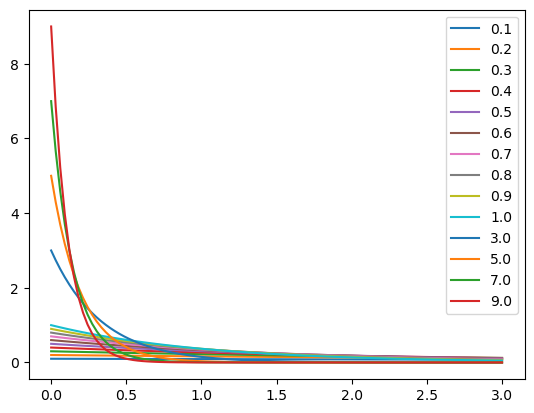

In [336]:
x = np.linspace(0.0, 3, 100)
lamb_list = np.hstack([np.arange(1.0, 10.0) / 10, np.arange(1.0, 10.0, 2)])
for lamb in lamb_list:
    plt.plot(x, exponent(x, lamb=lamb), label=lamb)
plt.legend()
# plt.xlim(0.0, 0.1)
plt.show()

1. Оформить разные моды для весов
2. Начальное значение вероятностей
3. Не давать увеличиваться скору

In [354]:
def optimal_control_custom(x_0, x_ref, time, f, F, n_samples, n_steps, mode='top-s', lamb=0.5, verbose=0):
    """
    params:
        x_0 - initial state
        x_ref - final reference state  
        time - time horizon
        f - differential equation
        F - objective function
        n_samples = K - number of samples
        mode - way of calculating weights of the samples
            'top-s' : lamb - proportion of the best solutions
            'expon' : lamb - parameter of the exponential distribution
        n_steps = N - number of steps
        verbose - output setting
            0 - show solutions
            1 - print objective values only
    returns:
        history: a dict with
            x - predicted state trjectory of x(t)
            i - given sequense of controls i(t)
            obj_val - corresponding objective value F(x, i)
        and some other items
    """
    p = np.ones_like(time) * 0.5
    history = {'p_trace' : [p], 'obj_val_trace': []}

    if mode == 'top-s':
        top_s = int(lamb * n_samples)
        w_func = lambda Obj: (Obj <= np.sort(Obj)[top_s-1]).astype(np.float64)
    else:
        w_func = lambda Obj: exponent(Obj, **kwargs)

    # main iteration loop : 6
    for step in range(n_steps):
        X = []
        Obj = []
        
        # sample and substitute solutions : 1-3
        I = sample(n_samples, p)
        for const_i in I:
            history_i = optimal_control_substituting(x_0, x_ref, time, f, F, const_i)
            X.append(history_i['x'])
            Obj.append(history_i['obj_val'])
        Obj = np.array(Obj)
        
        # find best solutions : 4
        # update probabilities : 5
        w = w_func(Obj)
        
        if verbose == 0:
            print('-'*100)
            print(f'Step {step}/{n_steps} | Objective value {Obj.min():.5f}')
            show_X(X, x_0, x_ref, time, w, p)
        if verbose == 1:
            print('-'*50)
            print(f'Step {step}/{n_steps} | Objective value {Obj.min():.5f}')
            
        p = np.average(I, axis=0, weights=w)
#         print('w:', np.around(w, 3))
#         print('p:', np.around(p, 3))

        history['obj_val_trace'].append(Obj)
        history['p_trace'].append(p)

    best_id = np.argmin(Obj)
    history['time'] = time
    history['x'] = X[best_id]
    history['i'] = I[best_id]
    history['obj_val'] = Obj[best_id]
    history['x_0'] = x_0
    history['x_ref'] = x_ref
    history['obj_val_trace'] = np.array(history['obj_val_trace'])
    history['p_trace'] = np.array(history['p_trace'])
    return history

In [364]:
histories = []
lamb_list = (0.5, 0.7)
n_steps = 5

for lamb in lamb_list:
    history_exp_lamb = optimal_control_custom(
        x_0, x_ref, time, f, F, n_samples=10, 
        mode='top-s', lamb=lamb, n_steps=n_steps, verbose=2
    )
    histories.append({
        'mode' : 'exponent',
        'param' : lamb,
        'history' : history_exp_lamb
    })

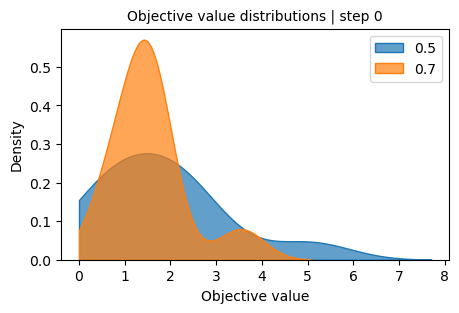

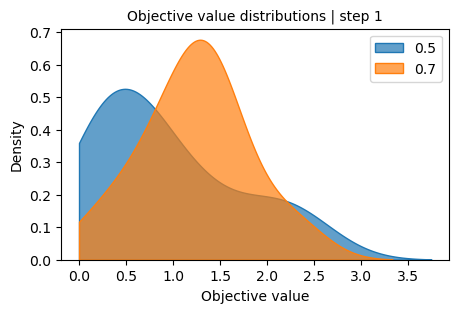

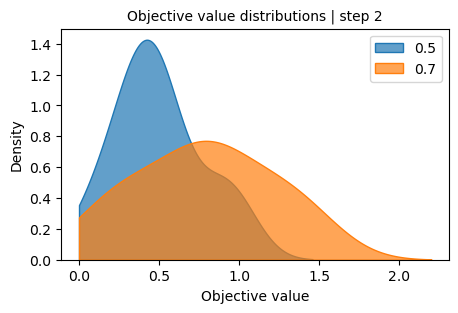

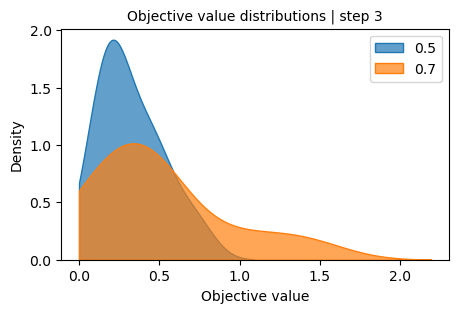

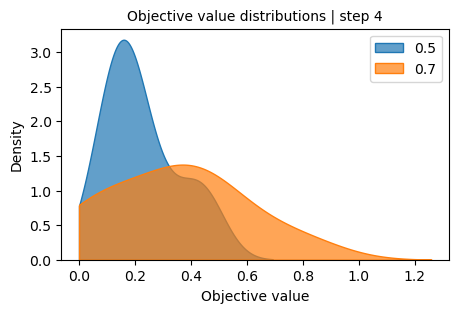

In [365]:
for step in range(n_steps):
    plt.figure(figsize=(5, 3))
    plt.title(f'Objective value distributions | step {step}', fontsize=10)
    for hist in histories:
        sns.kdeplot(data=hist['history']['obj_val_trace'][step], 
                    fill=True, alpha=0.7, clip=(0.0, None), label=hist['param'])
    plt.xlabel('Objective value', fontsize=10)
    plt.ylabel('Density', fontsize=10)
#     plt.ylim(0, 10)
    plt.legend()
    plt.show()